# Import of packages

The analysis pipeline uses 'autoprot' developed in our lab (https://doi.org/10.1101/2024.01.18.571429)

Autoprot is implemented in Python ≥ 3.9 and can be downloaded from https://github.com/ag-warscheid/autoprot. Online documentation is available at https://ag-warscheid.github.io/autoprot/.

In [1]:
import os
import urllib
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pylab as plt
import numpy as np
import itertools

import plotly.graph_objects as go
import plotly.express as px

import missingno as msn
import logomaker

from autoprot_dev import preprocessing as pp
from autoprot_dev import analysis as ana
from autoprot_dev import visualization as vis

from subprocess import run, PIPE

import warnings
warnings.filterwarnings('ignore')

cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9)

%matplotlib inline

import datetime

date = datetime.date.today().strftime('%Y%m%d')
dirname = os.getcwd()[:-8]
rootdir = dirname

#important that font get exportet properly
# plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['pdf.fonttype'] = 42



COLORS = [ "cyan", "#dede00", "#377eb8", "#ffff00", "#e68a00", "#99ccff", 
          "#00ffcc", "#ff99ff", "#00b386","pink", "magenta"]


HUE_ORDER = ['Mitochondria','Acidocalcisome','ER', 'Cytoplasm','Nucleus','Nuclear Pore',
             'Cytoskeleton','Plasma membrane','Golgi', 'Glycosomal matrix', 'Glycosomal membrane']

Checking R installation...
Loading required package: rrcovNA
Loading required package: rrcov
Loading required package: robustbase
Scalable Robust Estimators with High Breakdown Point (version 1.7-2)
Scalable Robust Estimators with High Breakdown Point for
Incomplete Data (version 0.4-15)
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: BiocManager
Bioconductor version '3.16' is out-of-date; the current release version '3.19'
is available with R version '4.4'; see https://bioconductor.org/install
Loading required package: devtools
Loading required package: usethis
Attaching package: ‘devtools’
The 

# Data Import

In [2]:
df = pd.read_csv("txt/proteinGroups.txt", sep='\t')
df.sample(1)

Protein IDs           Majority protein IDs  \
2927  Tb927.10.3610;Tb427_100040700  Tb927.10.3610;Tb427_100040700   

     Peptide counts (all) Peptide counts (razor+unique)  \
2927                  2;2                           2;2   

     Peptide counts (unique)  \
2927                     2;2   

                                          Fasta headers  Number of proteins  \
2927  hypothetical protein, conserved ;hypothetical ...                   2   

      Peptides  Razor + unique peptides  Unique peptides  ...    id  \
2927         2                        2                2  ...  2927   

      Peptide IDs  Peptide is razor  Mod. peptide IDs  \
2927   2325;23731         True;True        2578;26401   

                   Evidence IDs            MS/MS IDs    Best MS/MS  \
2927  22725;22726;218286;218287  21247;198701;198702  21247;198701   

      Oxidation (M) site IDs  Oxidation (M) site positions  Taxonomy IDs  
2927                     NaN                           NaN         -1;-1  

[1 rows x 297 columns]

In [3]:
df = pp.cleaning(df)

4759 rows before filter operation.
4447 rows after filter operation.


Removing the text string '.1-p1' present in the identifiers of the fasta file used for MQ search

In [4]:
df['Majority protein IDs'] = df['Majority protein IDs'].str.replace('.1-p1','')
df['Protein IDs'] = df['Protein IDs'].str.replace('.1-p1','')

In [5]:
df.filter(regex="Intensity ").columns

Index(['Intensity Rep1_Density_F11', 'Intensity Rep1_Density_F12',
       'Intensity Rep1_Density_F13', 'Intensity Rep1_Density_F14',
       'Intensity Rep1_Density_F15', 'Intensity Rep1_Density_F16',
       'Intensity Rep1_Density_F17', 'Intensity Rep1_Density_F18',
       'Intensity Rep1_Density_F19', 'Intensity Rep1_Density_F20',
       'Intensity Rep1_Density_F21', 'Intensity Rep1_Density_F22',
       'Intensity Rep1_MP', 'Intensity Rep1_SN0', 'Intensity Rep1_SN1',
       'Intensity Rep1_SN2', 'Intensity Rep1_Total_Glycosome',
       'Intensity Rep2_MP', 'Intensity Rep2_OP', 'Intensity Rep2_SN0',
       'Intensity Rep2_SN1', 'Intensity Rep2_SN2',
       'Intensity Rep2_Total_Glycosome', 'Intensity Rep3_MP',
       'Intensity Rep3_OP', 'Intensity Rep3_SN0', 'Intensity Rep3_SN1',
       'Intensity Rep3_SN2', 'Intensity Rep3_Total_Glycosome'],
      dtype='object')

# Marker annotation

In [6]:
marker = pp.read_csv("marker_list/Tb Markers CKK V03.txt")

In [7]:
marker.columns

Index(['Description', 'ProteinID_927', 'ProteinID_427', 'marker',
       'Trace_validated', 'Comments'],
      dtype='object')

In [8]:
df["UID"] = range(1, df.shape[0]+1)
df_copy = df.copy()
df_copy['Majority protein IDs'] = df_copy['Majority protein IDs'].str.split(';')
df_copy = df_copy.explode('Majority protein IDs')

In [9]:
merged_df = df_copy.merge(marker, left_on='Majority protein IDs', right_on='ProteinID_427', how='right')
merged_df = merged_df.groupby('UID').agg("max")
df2 = df.merge(merged_df, on='UID', how='left', suffixes=('', '_y'))
df2.drop(df2.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [10]:
df_marker = df2.copy(deep=True)

Visualizing first few and last few rows to identify correct merge:

In [11]:
df2[df2['marker']=='Glycosomal membrane'].iloc[:, :2].join(df2[df2['marker']=='Glycosomal membrane'].iloc[:, -6:])

Protein IDs  \
103   Tb927.10.15850;Tb427_100168100;Tb11.v5.0427   
526                  Tb427_030023100;Tb11.v5.0818   
530                  Tb427_030023800;Tb927.3.2410   
877                  Tb427_040043200;Tb927.4.4050   
2257                              Tb427_090036100   
2340                 Tb927.9.9430;Tb427_090053600   
2413                Tb427_090066100;Tb927.9.11580   
2414                Tb927.9.11600;Tb427_090066200   
3225               Tb927.10.14720;Tb427_100155500   
3443                              Tb427_110036300   
3808               Tb427_110111200;Tb927.11.10260   
3882               Tb427_110131800;Tb927.11.11520   

                             Majority protein IDs Description   ProteinID_927  \
103   Tb927.10.15850;Tb427_100168100;Tb11.v5.0427       PEX12  Tb927.10.15850   
526                  Tb427_030023100;Tb11.v5.0818        PEX2    Tb927.3.2340   
530                  Tb427_030023800;Tb927.3.2410       PEX10    Tb927.3.2410   
877                  Tb427_040043200;Tb927.4.4050        GAT1    Tb927.4.4050   
2257                              Tb427_090036100       PEX16    Tb927.9.6450   
2340                 Tb927.9.9430;Tb427_090053600     PEX13.2    Tb927.9.9430   
2413                Tb427_090066100;Tb927.9.11580       GIM5A   Tb927.9.11580   
2414                Tb927.9.11600;Tb427_090066200       GIM5B   Tb927.9.11600   
3225               Tb927.10.14720;Tb427_100155500    PEX13.1   Tb927.10.14720   
3443                              Tb427_110036300        GAT2   Tb927.11.3130   
3808               Tb427_110111200;Tb927.11.10260        PEX3  Tb927.11.10260   
3882               Tb427_110131800;Tb927.11.11520       PEX11  Tb927.11.11520   

        ProteinID_427               marker Trace_validated Comments  
103   Tb427_100168100  Glycosomal membrane             yes      NaN  
526   Tb427_030023100  Glycosomal membrane             yes      NaN  
530   Tb427_030023800  Glycosomal membrane             yes      NaN  
877   Tb427_040043200  Glycosomal membrane             yes      NaN  
2257  Tb427_090036100  Glycosomal membrane             yes      NaN  
2340  Tb427_090053600  Glycosomal membrane             yes      NaN  
2413  Tb427_090066100  Glycosomal membrane             yes      NaN  
2414  Tb427_090066200  Glycosomal membrane             yes      NaN  
3225  Tb427_100155500  Glycosomal membrane             yes      NaN  
3443  Tb427_110036300  Glycosomal membrane             yes      NaN  
3808  Tb427_110111200  Glycosomal membrane             yes      NaN  
3882  Tb427_110131800  Glycosomal membrane             yes      NaN

In [12]:
marker['marker'].value_counts()

marker
Nucleus                16
ER                     14
Glycosomal membrane    12
Glycosomal matrix      11
Golgi                  11
Cytoskeleton           11
Nuclear Pore           11
Plasma membrane        10
Acidocalcisome         10
Cytoplasm               8
Mitochondria            7
Name: count, dtype: int64

In [13]:
df2['marker'].value_counts()

marker
ER                     14
Glycosomal membrane    12
Glycosomal matrix      11
Cytoskeleton           10
Acidocalcisome          9
Golgi                   9
Nucleus                 8
Cytoplasm               7
Mitochondria            7
Nuclear Pore            7
Plasma membrane         6
Name: count, dtype: int64

In [14]:
df_main = df2.copy(deep=True)

In [15]:
# df2.to_csv("results/proteinGroups_with_markers.csv", index=False)

# Analysis 1: PCP of all conditions-

In [16]:
df_traces = df2.copy(deep=True)

In [17]:
df_traces.filter(regex='^iBAQ Rep').columns

Index(['iBAQ Rep1_Density_F11', 'iBAQ Rep1_Density_F12',
       'iBAQ Rep1_Density_F13', 'iBAQ Rep1_Density_F14',
       'iBAQ Rep1_Density_F15', 'iBAQ Rep1_Density_F16',
       'iBAQ Rep1_Density_F17', 'iBAQ Rep1_Density_F18',
       'iBAQ Rep1_Density_F19', 'iBAQ Rep1_Density_F20',
       'iBAQ Rep1_Density_F21', 'iBAQ Rep1_Density_F22', 'iBAQ Rep1_MP',
       'iBAQ Rep1_SN0', 'iBAQ Rep1_SN1', 'iBAQ Rep1_SN2',
       'iBAQ Rep1_Total_Glycosome', 'iBAQ Rep2_MP', 'iBAQ Rep2_OP',
       'iBAQ Rep2_SN0', 'iBAQ Rep2_SN1', 'iBAQ Rep2_SN2',
       'iBAQ Rep2_Total_Glycosome', 'iBAQ Rep3_MP', 'iBAQ Rep3_OP',
       'iBAQ Rep3_SN0', 'iBAQ Rep3_SN1', 'iBAQ Rep3_SN2',
       'iBAQ Rep3_Total_Glycosome'],
      dtype='object')

## Selecting iBAQ intensity columns for further analysis:

In [18]:
ointCol1 = ['iBAQ Rep1_Total_Glycosome', 'iBAQ Rep1_SN0', 'iBAQ Rep1_SN1',
       'iBAQ Rep1_SN2', 'iBAQ Rep1_MP']
ointCol2 = ['iBAQ Rep2_Total_Glycosome', 'iBAQ Rep2_SN0', 'iBAQ Rep2_SN1',
       'iBAQ Rep2_SN2', 'iBAQ Rep2_MP']
ointCol3 = ['iBAQ Rep3_Total_Glycosome', 'iBAQ Rep3_SN0', 'iBAQ Rep3_SN1',
       'iBAQ Rep3_SN2', 'iBAQ Rep3_MP']

ointCols = [ointCol1, ointCol2, ointCol3]

sumCols = ointCol1 + ointCol2 + ointCol3

In [19]:
df_traces = pp.remove_non_quant(df_traces, ointCol1 + ointCol2 + ointCol3)

4447 rows before filter operation.
4447 rows after filter operation.


In [20]:
intCols = []

for ointCol in ointCols:
    df_traces[ointCol] = df_traces[ointCol].replace(0, np.nan)
    df_traces, intCol = pp.log(df_traces, ointCol, base=10, return_cols=True)
    intCols.append(intCol)

In [ ]:
# df_traces["UID"] = range(1, df_traces.shape[0]+1)

<Axes: >

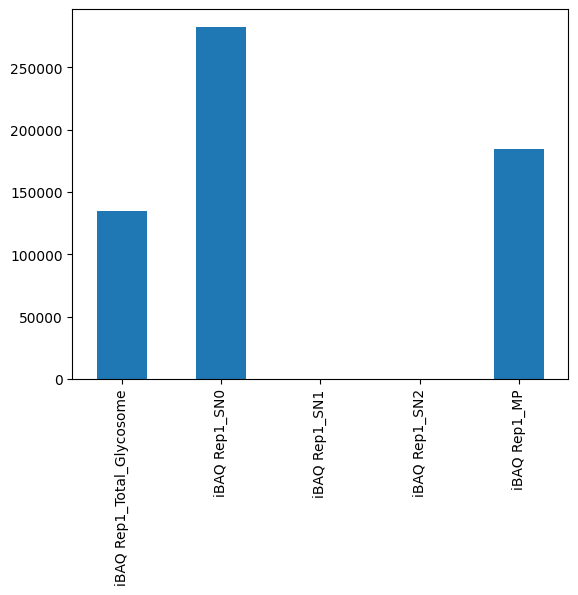

In [26]:
df[df['Majority protein IDs'].str.contains('Tb427_090008200')][ointCol1].mean().plot(kind='bar')

<Axes: >

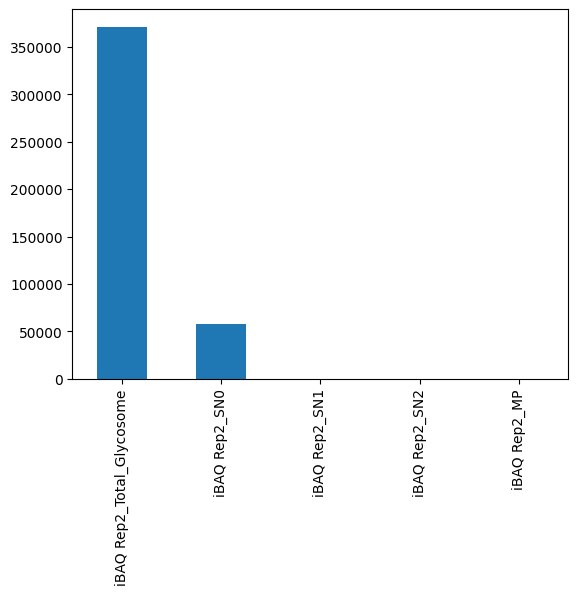

In [27]:
df[df['Majority protein IDs'].str.contains('Tb427_090008200')][ointCol2].mean().plot(kind='bar')

<Axes: >

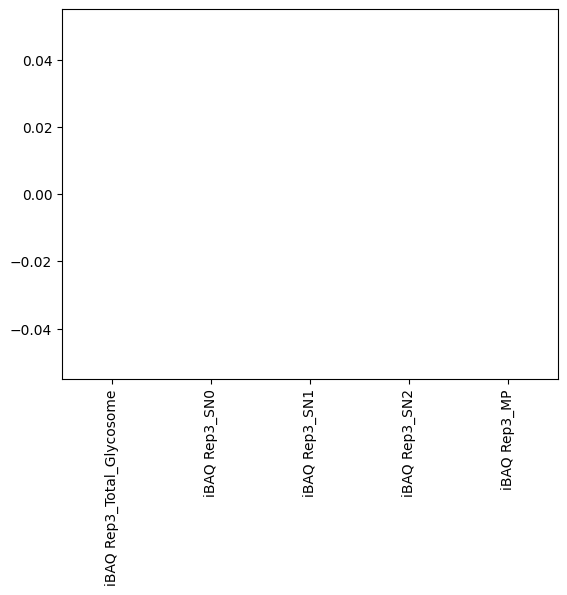

In [28]:
df[df['Majority protein IDs'].str.contains('Tb427_090008200')][ointCol3].mean().plot(kind='bar')

<Axes: >

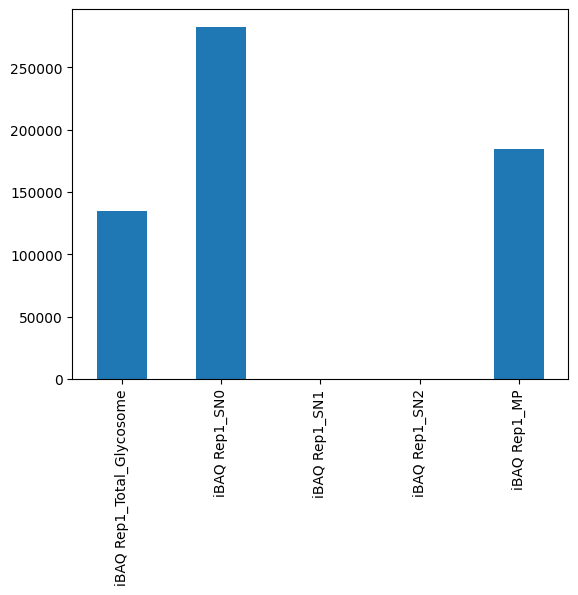

In [25]:
df_traces[df_traces['Majority protein IDs'].str.contains('Tb427_090008200')][ointCol1].mean().plot(kind='bar')

## Visualizing overlap of proteins identified in membrane pellet fraction of rep1, rep2 and rep3:

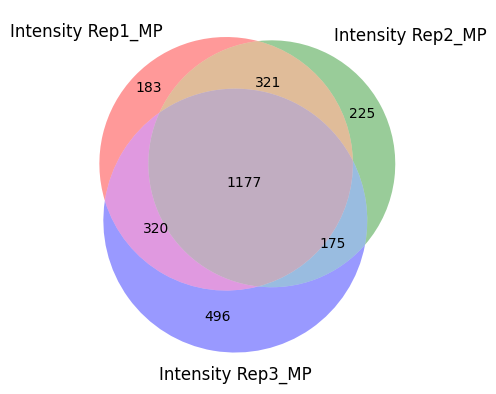

In [ ]:
vis.venn_diagram(df_traces[['Intensity Rep1_MP', 'Intensity Rep2_MP', 'Intensity Rep3_MP']].replace(0, np.nan))

## Data preprocessing for all reps:

In [ ]:
from sklearn.preprocessing import MinMaxScaler


for rep in range(3):
    intCol= intCols[rep]

    df_filter = df_traces.copy(deep=True)
    df_filter = pp.remove_non_quant(df_filter, intCol)
    ## Filtering dataset by rows which have at least 2 valid values out of 5 columns 'Total', 'SN', 'SN1','SN2', 'MP'
    """
    ## This is based on the assumption that a membrane protein may be enriched only in Total glycosomal and then 
    directly in the membrane pellet with missing values in the washing steps 'SN0', 'SN1' and 'SN2'.
    
    
    """
    df_filter = pp.filter_vv(df_filter, [intCol], n=2, valid_values=True)

    ## Imputing missing values for each row by randomly drawing values from downshifted distribution across rows:
    def impute_per_row(row):
        
        downshift = 1.8
        width = .3
        
        var = np.std(row)
        mean = np.mean(row)

        mean_ = mean - downshift*var
        var_ = var*width

        
        rnd = list(np.random.normal(mean_, var_, size=np.isnan(row).sum()))
        
        idx_noCtrl = row[row.isnull()].index
                
        for i, idx in enumerate(idx_noCtrl):
            row[idx] = rnd[i]
                
        return row
    
    df_filter[intCol] = df_filter[intCol].apply(impute_per_row, axis=1)

    
    df_norm2 = df_filter.copy(deep=True)
    
    ################  MIN-MAX NORMALIZATION ###############################
    df_norm2[intCol] = 10**df_norm2[intCol]

    df_norm2[intCol] = df_norm2[intCol].apply(lambda x: x/max(x), 1)

        
    df_norm2.to_csv("results/dataset1_rep" + str(rep+1) + ".csv", index=False)


4447 rows before filter operation.
2851 rows after filter operation.
2851 rows before filter operation.
1970 rows after filter operation.
4447 rows before filter operation.
2844 rows after filter operation.
2844 rows before filter operation.
1928 rows after filter operation.
4447 rows before filter operation.
3994 rows after filter operation.
3994 rows before filter operation.
2377 rows after filter operation.


## Loading preprocessed dataset from each replicate as a separate dataframe:

As each replicate dataframe is reduced after filtering for valid values and imputing missing values, we load each dataset separately.

In [ ]:
rep1 = pp.read_csv("results/dataset1_rep1.csv", sep=',')
rep2 = pp.read_csv("results/dataset1_rep2.csv", sep=',')
rep3 = pp.read_csv("results/dataset1_rep3.csv", sep=',')

## Visualization of traces for QC of marker proteins:

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def create_custom_legend(moi, COLORS=None, ax=None):
    if COLORS is None:
        # Use the 'qualitative' 'Set1' color palette from matplotlib
        COLORS = plt.cm.Set1.colors[:len(moi)]

    # Create a list of Line2D objects for the legend
    legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) for label, color in zip(moi, COLORS)]

    if ax is None:
        # If no axes object is provided, get the current axes
        ax = plt.gca()

    # Add the custom legend to the specified axes object
    ax.legend(handles=legend_elements, loc='best', fontsize='small', title="Marker/Protein")

    return ax

In [ ]:
intCol1 = ['log10_iBAQ Rep1_Total_Glycosome', 'log10_iBAQ Rep1_SN0',
       'log10_iBAQ Rep1_SN1', 'log10_iBAQ Rep1_SN2',
       'log10_iBAQ Rep1_MP']

intCol2 = ['log10_iBAQ Rep2_Total_Glycosome', 'log10_iBAQ Rep2_SN0',
       'log10_iBAQ Rep2_SN1', 'log10_iBAQ Rep2_SN2',
       'log10_iBAQ Rep2_MP']

intCol3 = ['log10_iBAQ Rep3_Total_Glycosome', 'log10_iBAQ Rep3_SN0',
       'log10_iBAQ Rep3_SN1', 'log10_iBAQ Rep3_SN2',
       'log10_iBAQ Rep3_MP']

### Visualizing mean of marker proteins per rep:

In [ ]:
moi = ['Mitochondria','Acidocalcisome','ER', 'Cytoplasm','Nucleus','Nuclear Pore',
             'Cytoskeleton','Plasma membrane','Golgi', 'Glycosomal matrix', 'Glycosomal membrane']

<Axes: ylabel='Norm. Intensity'>

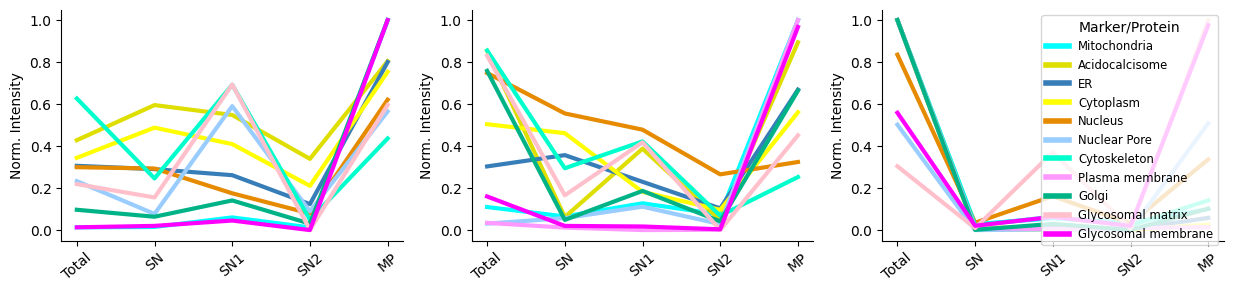

In [ ]:
# Main plotting code
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

for marker, col in zip(moi, COLORS):
    ticks = ['Total', 'SN', 'SN1','SN2', 'MP']
    # Plotting traces for the first replicate
    vis.plot_traces(rep1[rep1['marker'] == marker], intCol1, ax=ax[0], plot_summary_only=True, summary_color=col, ylabel='Norm. Intensity')
    ax[0].set_xticks(range(len(intCol1)), labels=ticks, rotation=40)

    # Plotting traces for the second replicate
    vis.plot_traces(rep2[rep2['marker'] == marker], intCol2, ax=ax[1], plot_summary_only=True, summary_color=col, ylabel='Norm. Intensity')
    ax[1].set_xticks(range(len(intCol2)), labels=ticks, rotation=40)

    # Plotting traces for the third replicate
    vis.plot_traces(rep3[rep3['marker'] == marker], intCol3, ax=ax[2], plot_summary_only=True, summary_color=col, ylabel='Norm. Intensity')
    ax[2].set_xticks(range(len(intCol3)), labels=ticks, rotation=40)

# Adding the custom legend to the last subplot (or to whichever subplot is most appropriate)
create_custom_legend(moi, COLORS, ax[2])


### Visualizing all proteins in a marker list:

In [ ]:
moi = ['Mitochondria','Cytoplasm','Glycosomal matrix', 'Glycosomal membrane']

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def create_custom_legend(moi, COLORS=None, ax=None):
    if COLORS is None:
        # Use the 'qualitative' 'Set1' color palette from matplotlib
        COLORS = plt.cm.Set1.colors[:len(moi)]

    # Create a list of Line2D objects for the legend
    legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) for label, color in zip(moi, COLORS)]

    if ax is None:
        # If no axes object is provided, get the current axes
        ax = plt.gca()

    # Add the custom legend to the specified axes object
    ax.legend(handles=legend_elements, loc='best', fontsize='small', title="Marker/Protein")

    return ax

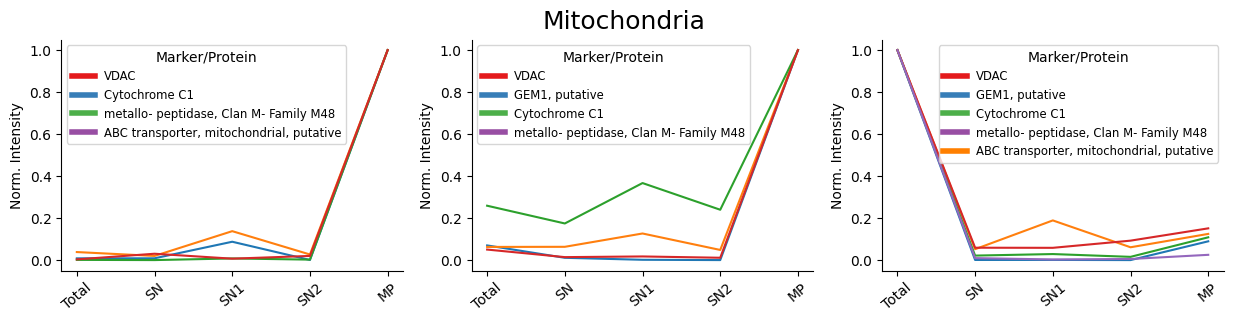

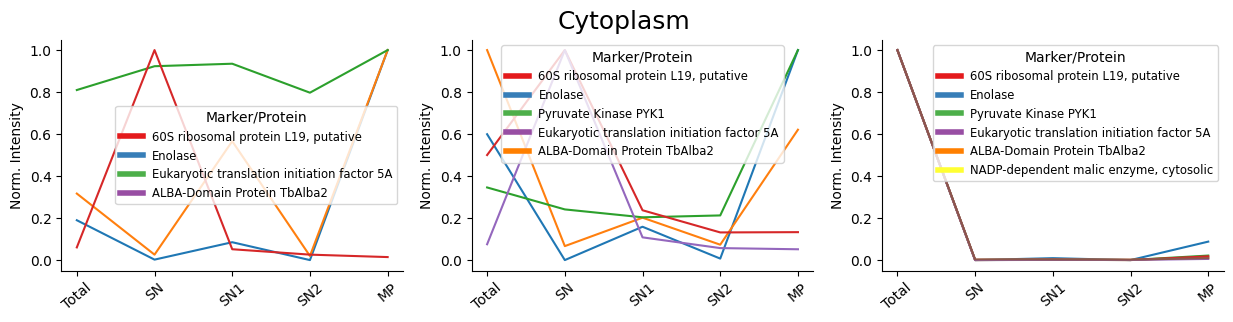

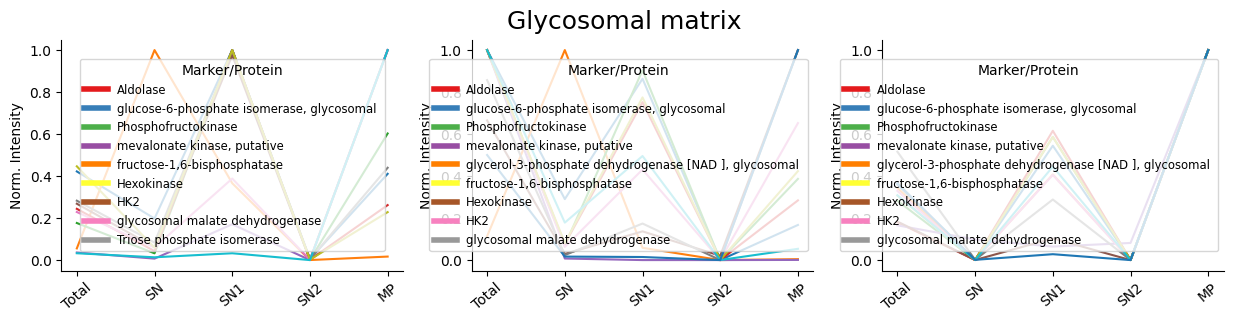

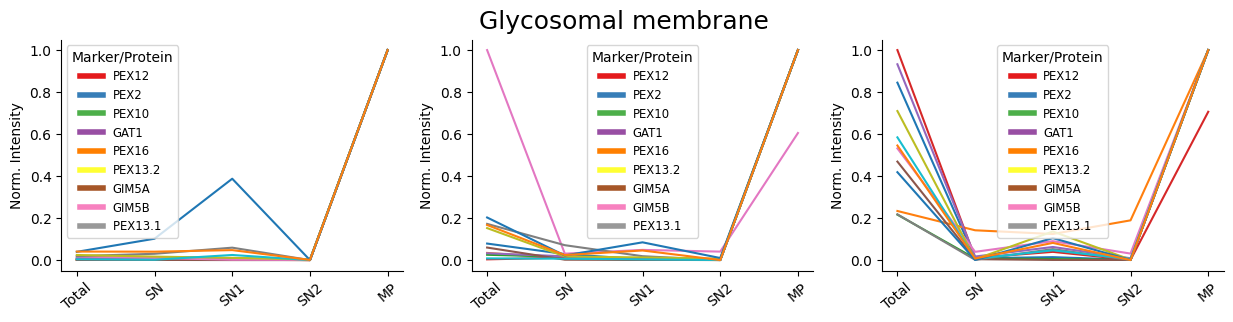

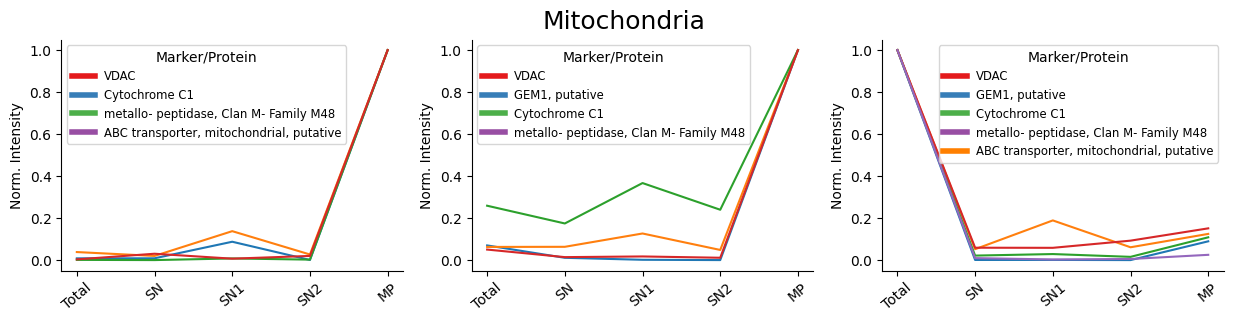

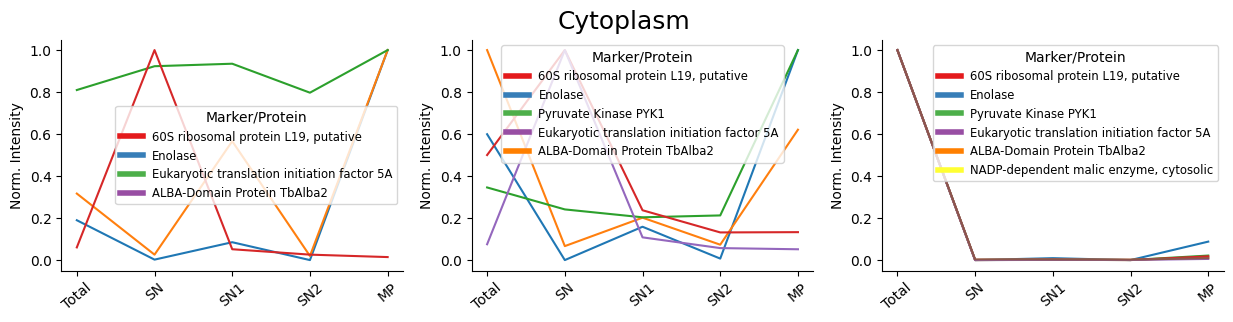

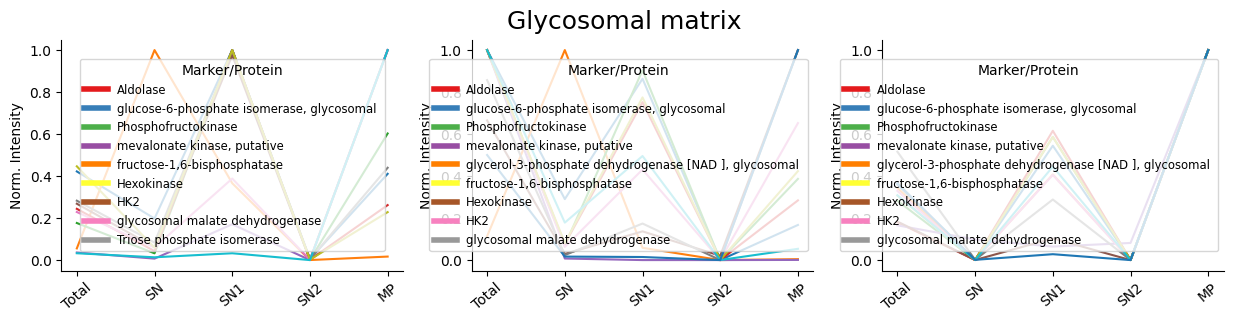

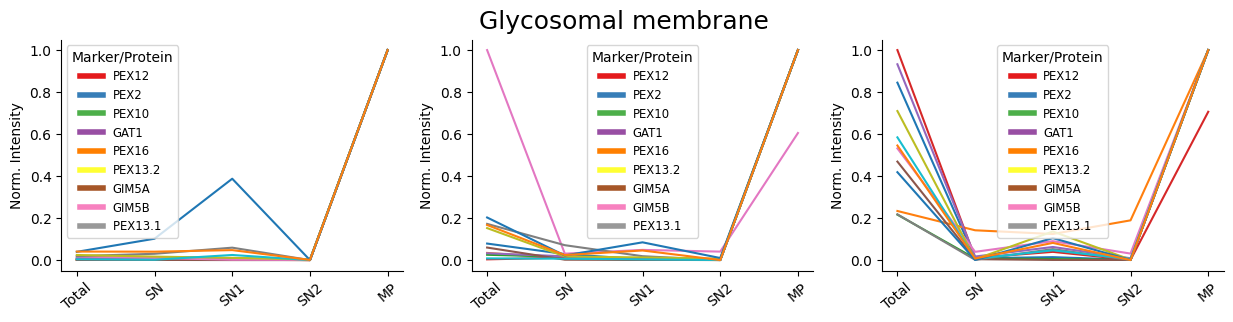

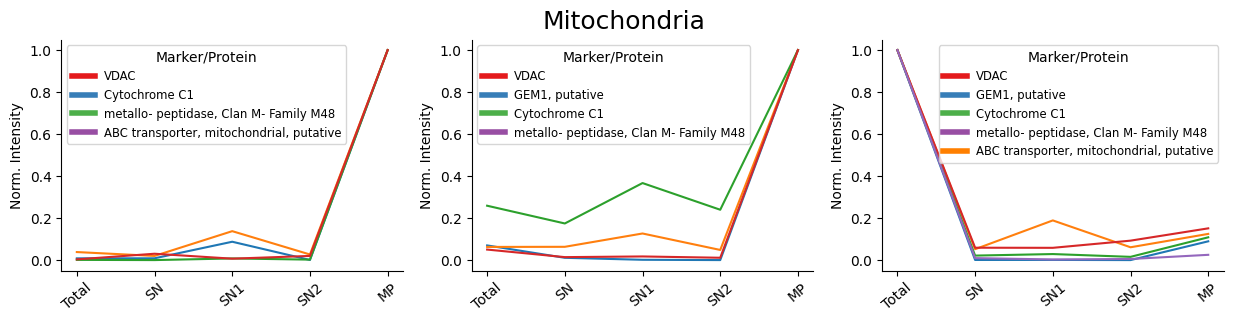

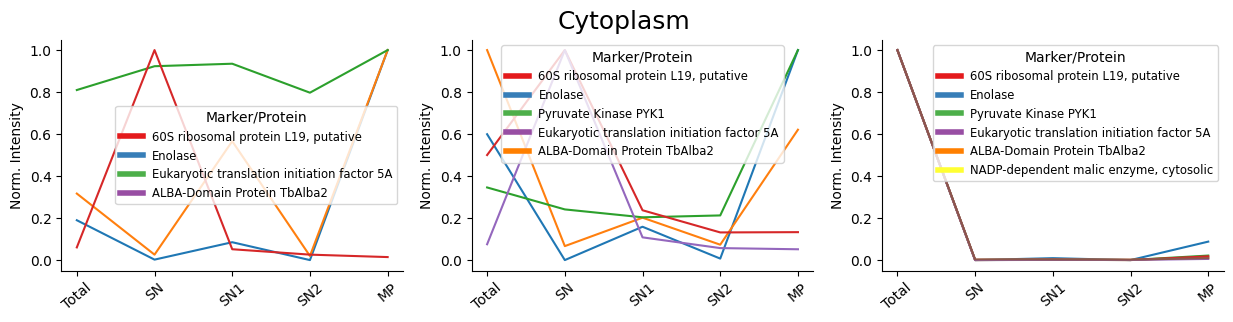

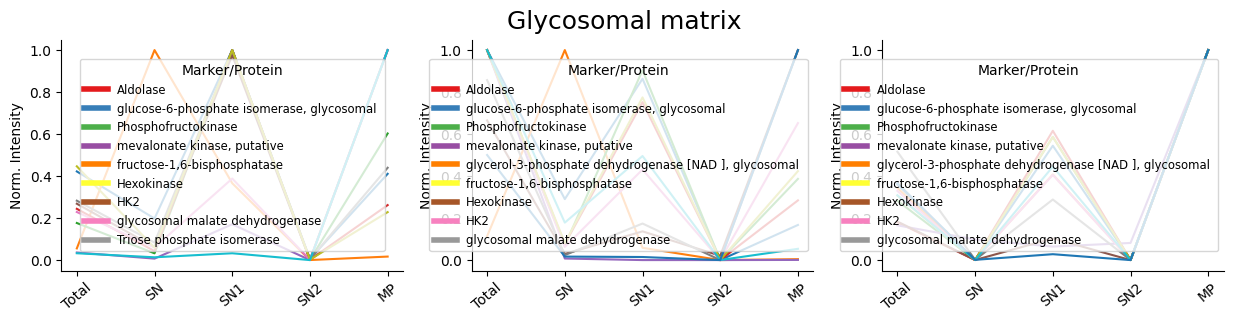

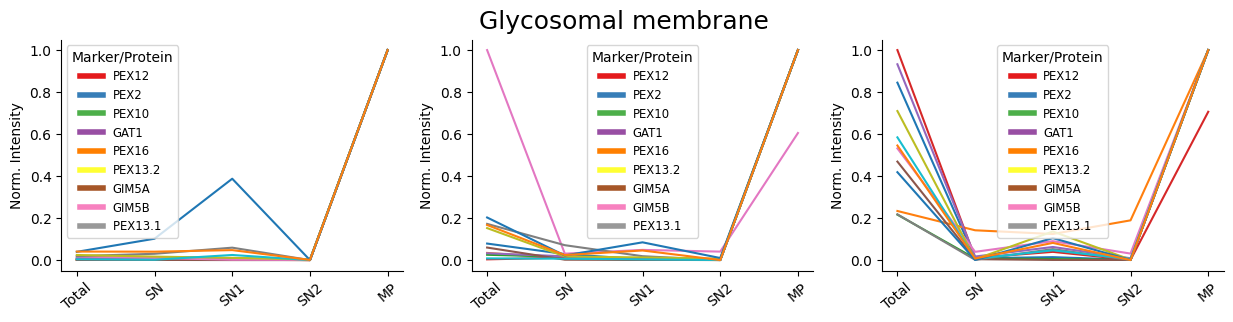

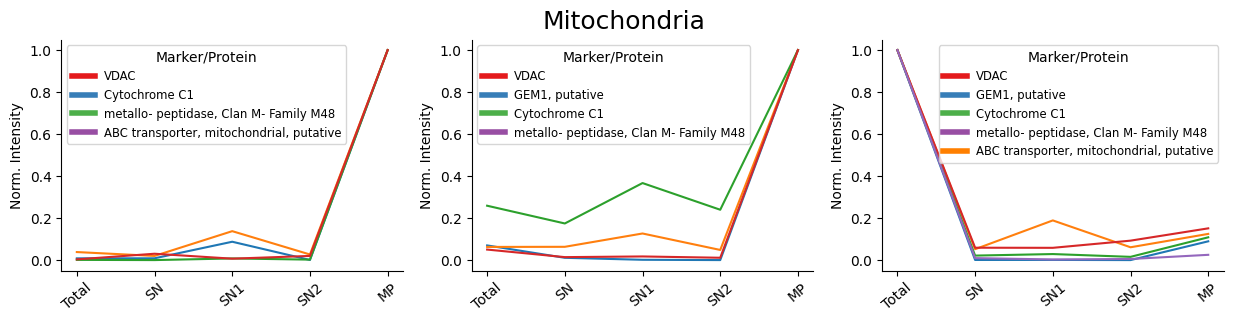

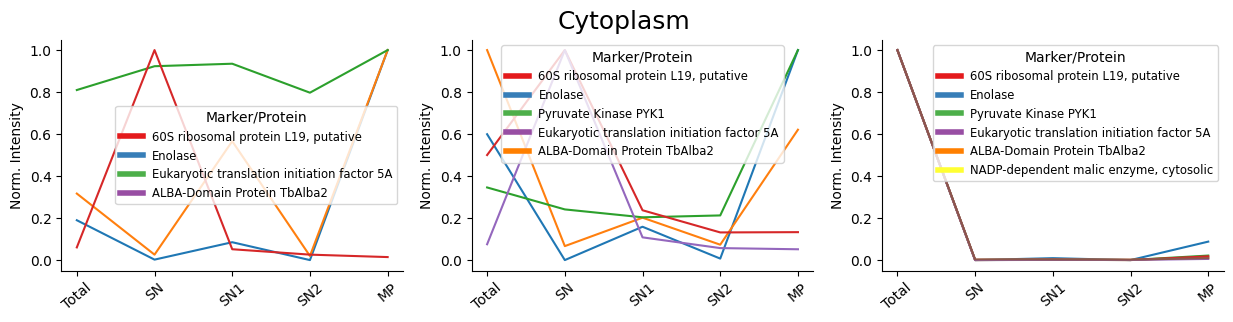

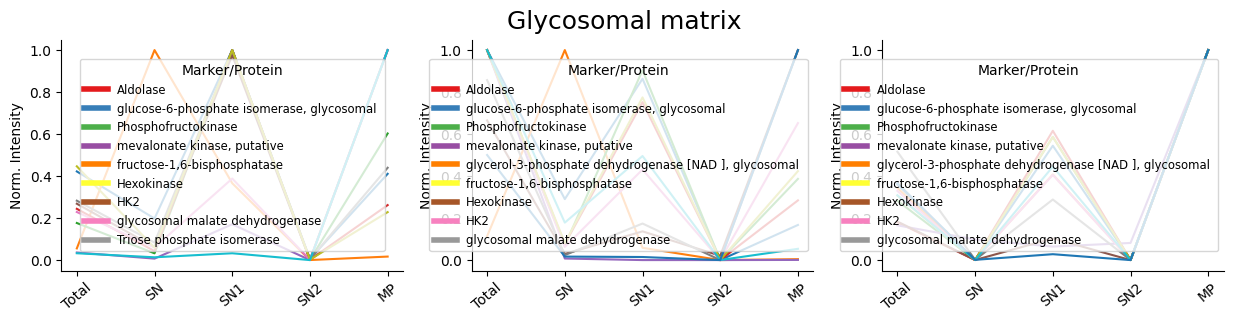

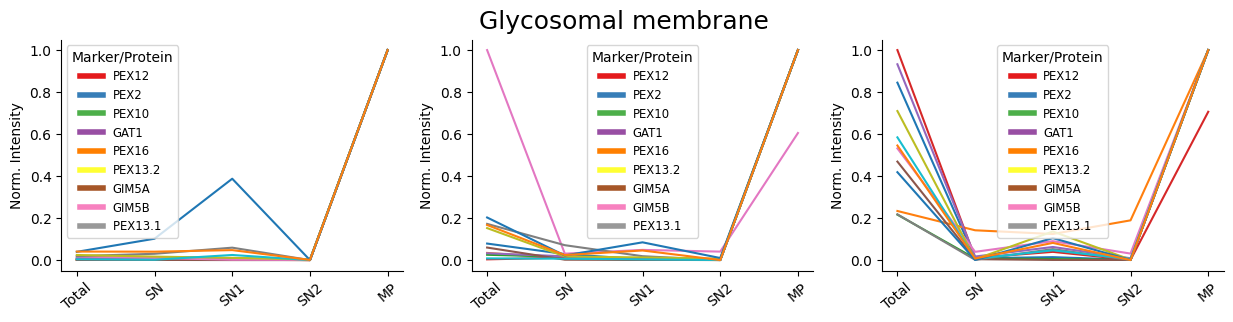

In [ ]:
# Main plotting code
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

for marker, col in zip(moi, COLORS):
    
    for m in moi:
        
        hlCol = COLORS[HUE_ORDER.index(marker)]
        
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
        fig.suptitle(m, size=18)
        
        ticks = ['Total', 'SN', 'SN1','SN2', 'MP']

        # Plotting traces for the first replicate
        vis.plot_traces(rep1[rep1['marker'] == m], intCol1, ax=ax[0], plot_summary_only=False, summary_color=col, ylabel='Norm. Intensity')
        ax[0].set_xticks(range(len(intCol1)), labels=ticks, rotation=40)
        create_custom_legend(rep1[rep1['marker'] == m]['Description'].to_list(), ax=ax[0])

        # Plotting traces for the second replicate
        vis.plot_traces(rep2[rep2['marker'] == m], intCol2, ax=ax[1], plot_summary_only=False, summary_color=col, ylabel='Norm. Intensity')
        ax[1].set_xticks(range(len(intCol2)), labels=ticks, rotation=40)
        create_custom_legend(rep2[rep2['marker'] == m]['Description'].to_list(), ax=ax[1])

        # Plotting traces for the third replicate
        vis.plot_traces(rep3[rep3['marker'] == m], intCol3, ax=ax[2], plot_summary_only=False, summary_color=col, ylabel='Norm. Intensity')
        ax[2].set_xticks(range(len(intCol3)), labels=ticks, rotation=40)
        create_custom_legend(rep3[rep3['marker'] == m]['Description'].to_list(), ax=ax[2])


## Merging all reps:

In [33]:
Rep1 = rep1[['id'] + rep1.filter(regex='log10_iBAQ Rep1').columns.to_list()]
Rep2 = rep2[['id'] + rep2.filter(regex='log10_iBAQ Rep2').columns.to_list()]
Rep3 = rep3[['id'] + rep3.filter(regex='log10_iBAQ Rep3').columns.to_list()]

In [34]:
Rep1['id'].duplicated().any()

False

In [35]:
df1 = df_marker.merge(Rep1, on='id', how='left')
df2 = df1.merge(Rep2, on='id', how='left')
df3 = df2.merge(Rep3, on='id', how='left')

In [36]:
intCol1

['log10_iBAQ Rep1_Total_Glycosome',
 'log10_iBAQ Rep1_SN0',
 'log10_iBAQ Rep1_SN1',
 'log10_iBAQ Rep1_SN2',
 'log10_iBAQ Rep1_MP']

In [37]:
df3.head(3)

Protein IDs  \
0  Tb927.5.4460;Tb427_050052000;Tb05.5K5.110;Tb11...   
1          Tb927.5.4470;Tb427_050052100;Tb05.5K5.120   
2          Tb927.5.4480;Tb427_050052200;Tb05.5K5.130   

                                Majority protein IDs Peptide counts (all)  \
0  Tb927.5.4460;Tb427_050052000;Tb05.5K5.110;Tb11...          22;22;22;13   
1          Tb927.5.4470;Tb427_050052100;Tb05.5K5.120                4;4;4   
2          Tb927.5.4480;Tb427_050052200;Tb05.5K5.130             44;44;44   

  Peptide counts (razor+unique) Peptide counts (unique)  \
0                   22;22;22;13             22;22;22;13   
1                         4;4;4                   4;4;4   
2                      44;44;44                44;44;44   

                                       Fasta headers  Number of proteins  \
0  major vault protein, putative ;Major Vault Pro...                   4   
1  hypothetical protein, conserved ;hypothetical ...                   3   
2  paraflagellar rod component par4, putative ;hy...                   3   

   Peptides  Razor + unique peptides  Unique peptides  ...  \
0        22                       22               22  ...   
1         4                        4                4  ...   
2        44                       44               44  ...   

   log10_iBAQ Rep2_Total_Glycosome  log10_iBAQ Rep2_SN0  log10_iBAQ Rep2_SN1  \
0                              NaN                  NaN                  NaN   
1                              NaN                  NaN                  NaN   
2                         0.828026             0.503052                  1.0   

   log10_iBAQ Rep2_SN2  log10_iBAQ Rep2_MP  log10_iBAQ Rep3_Total_Glycosome  \
0                  NaN                 NaN                              NaN   
1                  NaN                 NaN                              1.0   
2             0.001136            0.001509                              1.0   

   log10_iBAQ Rep3_SN0  log10_iBAQ Rep3_SN1  log10_iBAQ Rep3_SN2  \
0                  NaN                  NaN                  NaN   
1             0.077549             0.080105             0.034475   
2             0.019405             0.066131             0.049209   

   log10_iBAQ Rep3_MP  
0                 NaN  
1            0.157357  
2            0.148957  

[3 rows x 316 columns]

## PCP of conditions:

In [38]:
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import auc

def calcMagnitude(y1,y2):
    auca = auc(range(len(y1)), y1)
    aucb = auc(range(len(y2)), y2)
    mcomp = (auca-aucb)/(auca+aucb)
    return abs(mcomp)

def calcCorr(y1,y2):
    #center traces 
    y1 = [i-np.mean(y1) for i in y1]
    y2 = [i-np.mean(y2) for i in y2]
    #scale traces
#     y1 = [(i-np.mean(y1))/np.std(y1, ddof=1) for i in y1]
#     y2 = [(i-np.mean(y2))/np.std(y2, ddof=1) for i in y2]    
    #return pearsonr(y1,y2)[0]
    return pearsonr(y1, y2)[0]

def calcSim(y1, y2):
    pComp = calcCorr(y1,y2)
    mComp = calcMagnitude(y1,y2)
#     print("p")
#     print(pComp)
#     print("m")
#     print(mComp)
    if pComp < 0 and mComp < 0:
        return np.nan
    return -np.log10(pComp*mComp)



reps = [rep1, rep2, rep3]
ints = [intCol1, intCol2, intCol3]

poisIdx1,poisIdx2,poisIdx3 = [],[],[]
poisIdx = [poisIdx1, poisIdx2, poisIdx3]
sim1, sim2, sim3 = [],[],[]
maxSims = [sim1, sim2, sim3]
dcorr1, dcorr2, dcorr3 = [], [], []
dcorrs = [dcorr1, dcorr2, dcorr3]

for rep, inte, pois, sim, dcorr in zip(reps, ints, poisIdx, maxSims, dcorrs):
    poxMean = rep.loc[rep["marker"]=='Glycosomal membrane',inte].mean(0)
    
    
    for i in range(rep.shape[0]):
        test = rep.iloc[i][inte].astype(float)

        poxSim = calcCorr(poxMean, test)
        dcorr.append(poxSim)
        
        
        sims = [poxSim]
        sims = [i if ~np.isnan(i) else 0 for i in sims]

        if sum(sims) == 0:
            idx=-999
        else:
            try:
                idx = sims.index(max(sims))
            except:
                idx = -999

        if idx == 0:
            poisIdx.append(i)

        sim.append(idx)  

In [39]:
rep1["dcorr_Glyco-mem"] = dcorrs[0]
rep2["dcorr_Glyco-mem"] = dcorrs[1]
rep3["dcorr_Glyco-mem"] = dcorrs[2]

<Axes: >

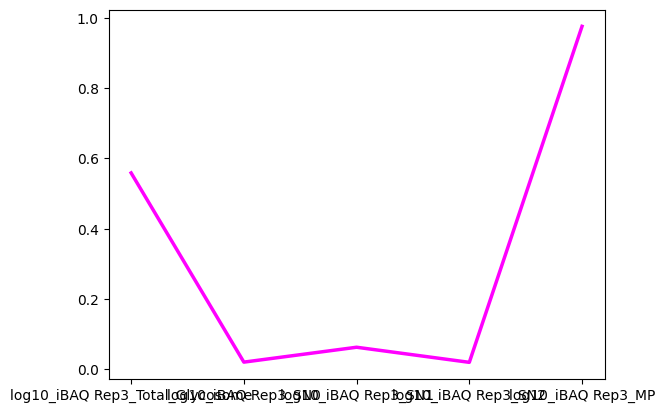

In [40]:
import seaborn as sns
sns.lineplot(data = poxMean.transpose(), linewidth=2.5, dashes =True, legend = 'auto', color="magenta")

Merging dataframes:

In [41]:
rep_1 =  rep1[['id','dcorr_Glyco-mem']]
rep_1 = rep_1.add_suffix("_Rep1")
df_merge1 = df3.merge(rep_1[['id_Rep1','dcorr_Glyco-mem_Rep1']], left_on='id',right_on='id_Rep1',how='left')

rep_2 =  rep2[['id','dcorr_Glyco-mem']]
rep_2 = rep_2.add_suffix("_Rep2")
df_merge2 = df_merge1.merge(rep_2[['id_Rep2','dcorr_Glyco-mem_Rep2']], left_on='id',right_on='id_Rep2',how='left')

rep_3 =  rep3[['id','dcorr_Glyco-mem']]
rep_3 = rep_3.add_suffix("_Rep3")
df_merge3 = df_merge2.merge(rep_3[['id_Rep3','dcorr_Glyco-mem_Rep3']], left_on='id',right_on='id_Rep3',how='left')

In [42]:
df_pcp = df_merge3.copy(deep=True)

In [43]:
corr_col = ['dcorr_Glyco-mem_Rep1', 'dcorr_Glyco-mem_Rep2', 'dcorr_Glyco-mem_Rep3']

In [44]:
df_pcp[corr_col]

dcorr_Glyco-mem_Rep1  dcorr_Glyco-mem_Rep2  dcorr_Glyco-mem_Rep3
0                 0.982050                   NaN                   NaN
1                      NaN                   NaN              0.394962
2                -0.352407             -0.501958              0.403827
3                 0.932743              0.177724              0.339023
4                      NaN                   NaN                   NaN
...                    ...                   ...                   ...
4442                   NaN                   NaN                   NaN
4443                   NaN                   NaN                   NaN
4444              0.004394             -0.162584              0.409464
4445                   NaN                   NaN                   NaN
4446                   NaN                   NaN                   NaN

[4447 rows x 3 columns]

In [45]:
df_pcp = pp.filter_vv(df_pcp, [corr_col], n=2, valid_values=True)

4447 rows before filter operation.
2046 rows after filter operation.


In [46]:
df_pcp = pp.imp_seq(df_pcp, corr_col)

In [47]:
df_pcp.filter(regex='_imputed').columns

Index(['dcorr_Glyco mem_Rep1_imputed', 'dcorr_Glyco mem_Rep2_imputed',
       'dcorr_Glyco mem_Rep3_imputed'],
      dtype='object')

In [48]:
corr_col = ['dcorr_Glyco mem_Rep1_imputed', 'dcorr_Glyco mem_Rep2_imputed','dcorr_Glyco mem_Rep3_imputed']

## Rank-Product Test:

In [49]:
df_rank1 = ana.rank_prod(df_pcp, reps=['dcorr_Glyco-mem_Rep1', 'dcorr_Glyco-mem_Rep2', 'dcorr_Glyco-mem_Rep3'], cond='_Glyco-mem_PCP', correct_fc = True)

rankProd: Assuming a one sample test


## Interactive plots PCP Analysis 1: 

In [50]:
key = 'class1>class2_Glyco-mem_PCP'

In [51]:
list(df_pcp.columns)

['Protein IDs',
 'Majority protein IDs',
 'Peptide counts (all)',
 'Peptide counts (razor+unique)',
 'Peptide counts (unique)',
 'Fasta headers',
 'Number of proteins',
 'Peptides',
 'Razor + unique peptides',
 'Unique peptides',
 'Peptides Rep1_Density_F11',
 'Peptides Rep1_Density_F12',
 'Peptides Rep1_Density_F13',
 'Peptides Rep1_Density_F14',
 'Peptides Rep1_Density_F15',
 'Peptides Rep1_Density_F16',
 'Peptides Rep1_Density_F17',
 'Peptides Rep1_Density_F18',
 'Peptides Rep1_Density_F19',
 'Peptides Rep1_Density_F20',
 'Peptides Rep1_Density_F21',
 'Peptides Rep1_Density_F22',
 'Peptides Rep1_MP',
 'Peptides Rep1_SN0',
 'Peptides Rep1_SN1',
 'Peptides Rep1_SN2',
 'Peptides Rep1_Total_Glycosome',
 'Peptides Rep2_MP',
 'Peptides Rep2_OP',
 'Peptides Rep2_SN0',
 'Peptides Rep2_SN1',
 'Peptides Rep2_SN2',
 'Peptides Rep2_Total_Glycosome',
 'Peptides Rep3_MP',
 'Peptides Rep3_OP',
 'Peptides Rep3_SN0',
 'Peptides Rep3_SN1',
 'Peptides Rep3_SN2',
 'Peptides Rep3_Total_Glycosome',
 'Raz

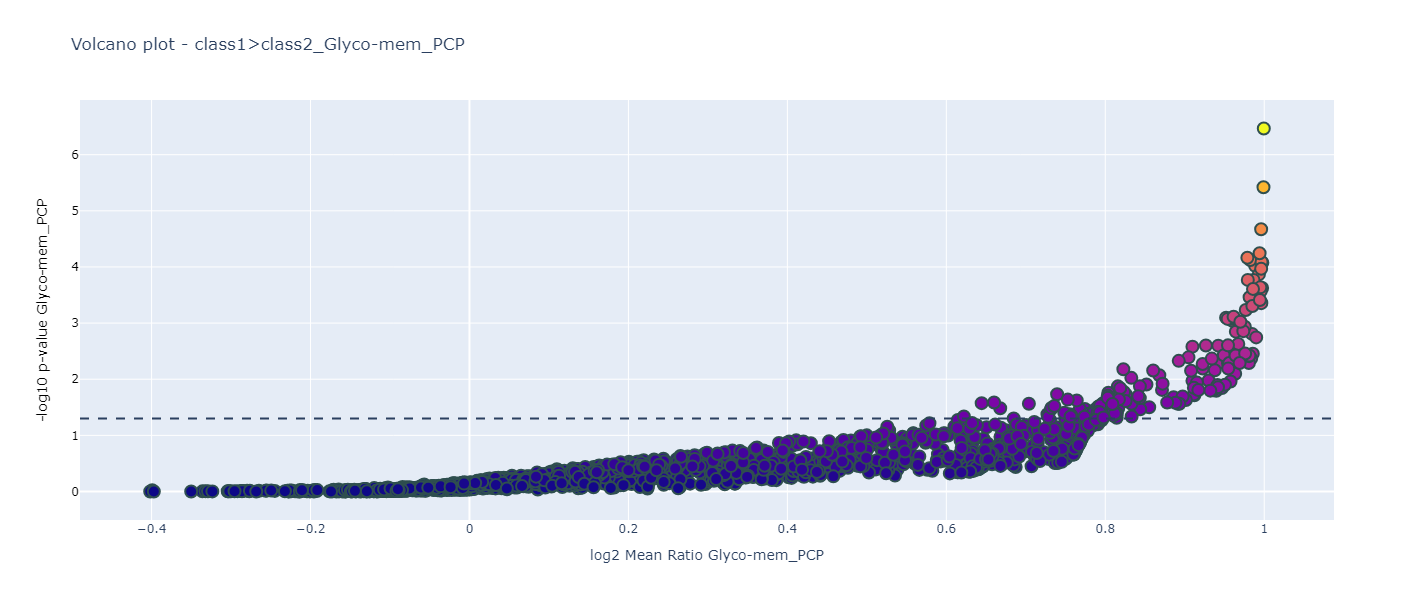

In [52]:
#### PLOTLY INTERACTIVE PLOT ####
key = 'class1>class2_Glyco-mem_PCP'
df_rank1['negative_PValue'] = np.log10(df_rank1['PValue_' + key]) * (-1)

fig = go.Figure()
trace1 = go.Scatter(
 x=df_rank1['logFC_Glyco-mem_PCP'],
 y=df_rank1['negative_PValue'],
 mode='markers',
    marker_color=df_rank1['negative_PValue'],
 hovertext = [
    f"{protein_ids.split(';')[0]}; {fasta_header1.split(';')[0]}"
    for protein_ids, fasta_header1 in zip(
        df_rank1["Majority protein IDs"],
        df_rank1["Fasta headers"].fillna('')
    )
]
)

fig.add_trace(trace1)
# fig.add_trace(trace2)
# fig.add_trace(trace3)
# fig.add_trace(trace4)
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.add_hline(y=1.3, line_dash="dash")
#fig.add_vline(x=1, line_dash="dash")
#fig.add_vline(x=-1, line_dash="dash")
fig.update_layout(title='Volcano plot - ' + key ,xaxis=dict(title="log2 Mean Ratio Glyco-mem_PCP"),
    yaxis=dict(title="-log10 p-value Glyco-mem_PCP"),
    autosize=False,
    width=800,  # Set the width of the figure
    height=600)  # Set the height of the figure)
#fig.update_layout(plot_bgcolor="white")
fig.update_yaxes(color='black', layer='above traces')

fig.show()
# fig.write_html(rootdir + r"/PCP_Glyco-membrane_v02.html")

## Volcano plots:

In [53]:
df_rank1[df_rank1['marker']=='Glycosomal membrane'].index

Index([41, 233, 234, 382, 1024, 1066, 1103, 1104, 1469, 1571, 1745, 1780], dtype='int64', name='index')

In [54]:
df_rank1["Majority protein IDs_1st"] = df_rank1["Majority protein IDs"].str.split(";").str.get(0)

(0.0, 1.02)

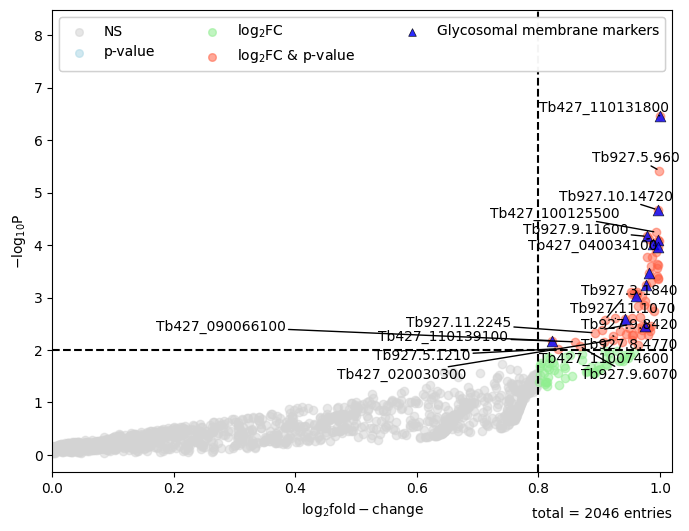

In [55]:
fig = vis.volcano(df_rank1,log_fc_colname="logFC_Glyco-mem_PCP", 
            p_colname='PValue_class1>class2_Glyco-mem_PCP',
            p_thresh=0.01,log_fc_thresh = 0.8,
            highlight = df_rank1[df_rank1['marker']=='Glycosomal membrane'].index, 
            annotate_colname = "Majority protein IDs_1st",
            figsize= (8, 6),
            annotate_density=100,
           kwargs_highlight={
            'color': 'blue', # set highlight color to red
            'marker': '^', # set highlight shape to circle
            's': 60, # set highlight size to 100
            'alpha': 0.8, # set highlight alpha to 0.8
            'edgecolors': 'black', # set highlight edge colors to black
            'linewidths': 0.5, # set highlight linewidths to 0.5
            'label': 'Glycosomal membrane markers'# set highlight label
        }
    )
plt.xlim(0,1.02)
# plt.savefig(rootdir + '/VolcanoPlot_new_candidates.pdf')

(0.0, 1.02)

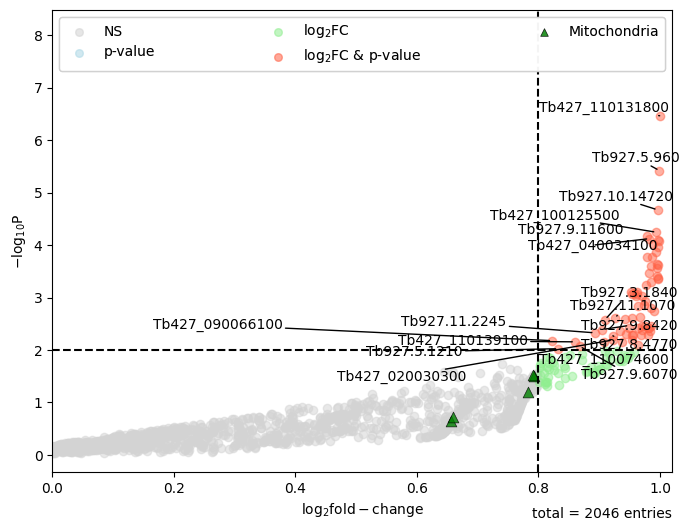

In [56]:
fig = vis.volcano(df_rank1,log_fc_colname="logFC_Glyco-mem_PCP", 
            p_colname='PValue_class1>class2_Glyco-mem_PCP',
            p_thresh=0.01,log_fc_thresh = 0.8,
            highlight = df_rank1[df_rank1['marker']=='Mitochondria'].index, 
            annotate_colname = "Majority protein IDs_1st",
            figsize= (8, 6),
            annotate_density=100,
           kwargs_highlight={
            'color': 'green', # set highlight color to red
            'marker': '^', # set highlight shape to circle
            's': 60, # set highlight size to 100
            'alpha': 0.8, # set highlight alpha to 0.8
            'edgecolors': 'black', # set highlight edge colors to black
            'linewidths': 0.5, # set highlight linewidths to 0.5
            'label': 'Mitochondria'# set highlight label
        }
    )
plt.xlim(0,1.02)
# plt.savefig(rootdir + '/VolcanoPlot_new_candidates.pdf')

In [57]:
# list(df_rank1["Majority protein IDs"]+ '; ' +  df_rank1["Description"].fillna(''))

## Data export:

In [58]:
df_rank1.to_csv( "results/PCP_dataset1_combined.csv", index=False)

# Analysis 2: PCP of Density-gradient fractions:

## Selecting density-gradient rows:

In [59]:
df = df_marker.copy(deep=True)

In [60]:
ointCols = ['iBAQ Rep1_Density_F11', 'iBAQ Rep1_Density_F12',
       'iBAQ Rep1_Density_F13', 'iBAQ Rep1_Density_F14',
       'iBAQ Rep1_Density_F15', 'iBAQ Rep1_Density_F16',
       'iBAQ Rep1_Density_F17', 'iBAQ Rep1_Density_F18',
       'iBAQ Rep1_Density_F19', 'iBAQ Rep1_Density_F20',
       'iBAQ Rep1_Density_F21', 'iBAQ Rep1_Density_F22']

In [61]:
df[ointCols] = df[ointCols].replace(0, np.nan)

In [62]:
df2 = pp.remove_non_quant(df, ointCols)

4447 rows before filter operation.
4306 rows after filter operation.


In [63]:
df2, intCols = pp.log(df2, ointCols, base=10, return_cols=True)

In [64]:
df2["UID"] = range(1, df2.shape[0]+1)

Visualization of missing values:

True

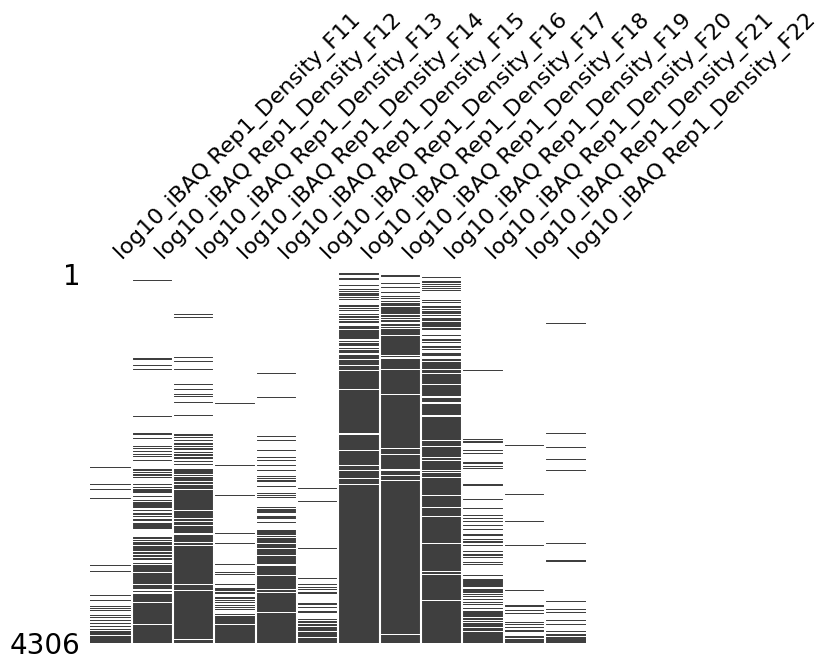

In [65]:
ana.miss_analysis(df2, intCols, text=False, vis=False, extra_vis=True, save_dir=None)

## PCP of density-fractions:

4306 rows before filter operation.
3932 rows after filter operation.


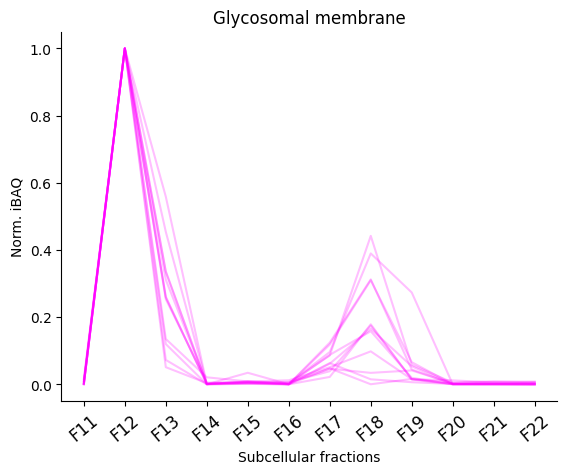

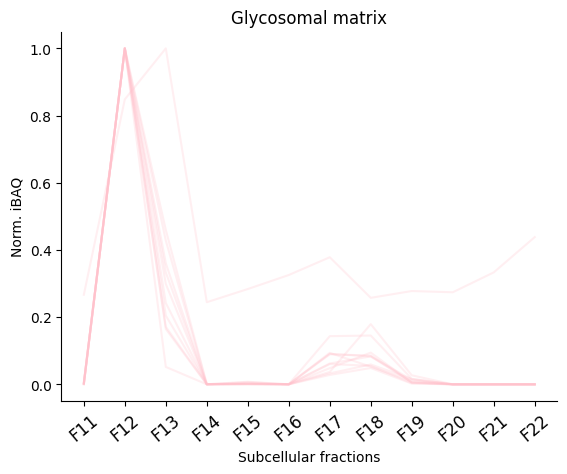

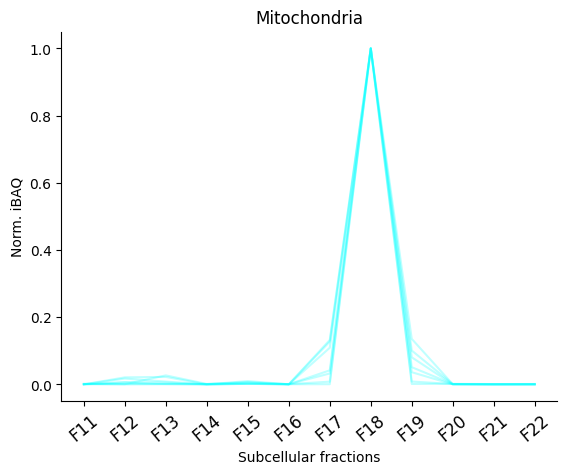

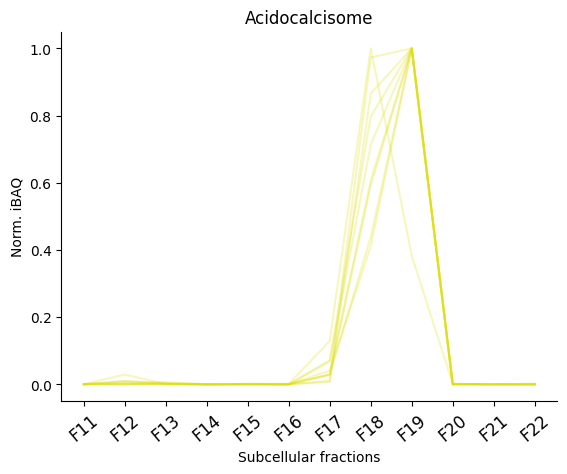

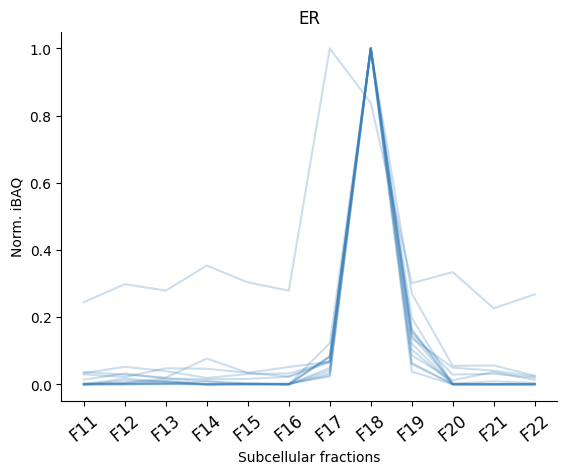

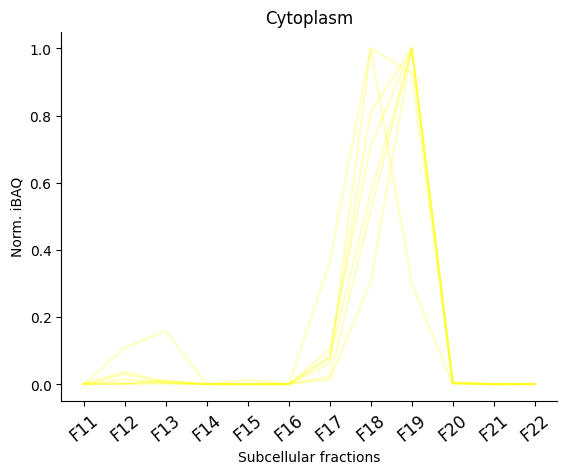

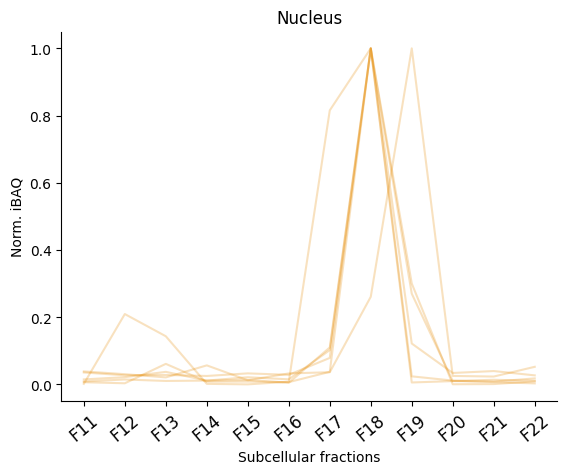

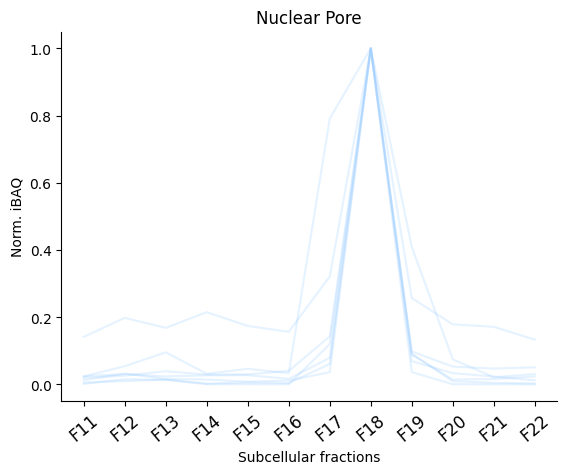

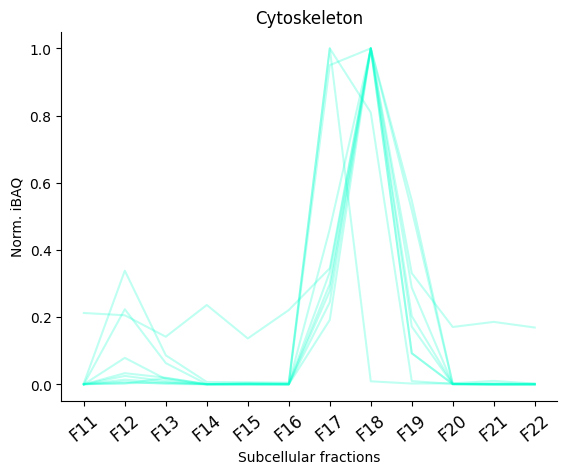

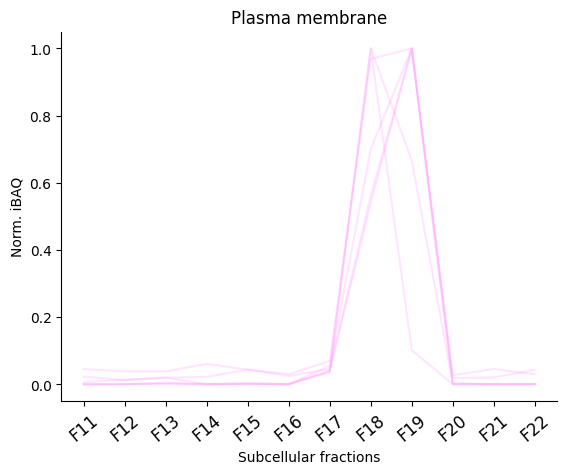

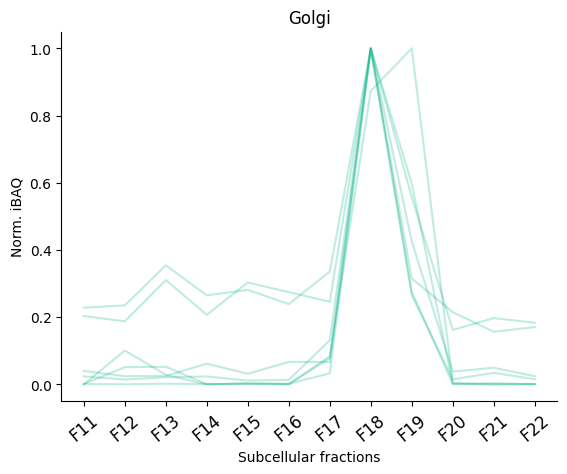

In [66]:
from sklearn.preprocessing import MinMaxScaler

intCol= intCols

df_filter = df2.copy(deep=True)
df_filter = pp.filter_vv(df_filter, [intCol], n=2, valid_values=True)

# df_filter[intCols1].to_csv(rootdir + "/data/rawIntCols_hd015.tsv", sep='\t', index=False)

def impute_per_row(row):

    downshift = 1.8
    width = .3

    var = np.std(row)
    mean = np.mean(row)

    mean_ = mean - downshift*var
    var_ = var*width

    #mean_ = 2
    #var_ = .3

    rnd = list(np.random.normal(mean_, var_, size=np.isnan(row).sum()))

    idx_noCtrl = row[row.isnull()].index

    for i, idx in enumerate(idx_noCtrl):
        row[idx] = rnd[i]

    return row

df_filter[intCol] = df_filter[intCol].apply(impute_per_row, axis=1)

df_norm2 = df_filter.copy(deep=True)

################  MIN-MAX NORMALIZATION ###############################
df_norm2[intCol] = 10**df_norm2[intCol]

df_norm2[intCol] = df_norm2[intCol].apply(lambda x: x/max(x), 1)

########Traces################

moi = ['Glycosomal membrane', 'Glycosomal matrix','Mitochondria','Acidocalcisome',
           'ER', 'Cytoplasm','Nucleus','Nuclear Pore','Cytoskeleton','Plasma membrane','Golgi']

for marker in moi:

    hlCol = COLORS[HUE_ORDER.index(marker)]

#         fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
#         plt.title(marker, size=18)
    forVis = df_norm2[df_norm2["marker"]==marker]

    
    ticks = ['F11','F12', 'F13','F14','F15','F16', 'F17','F18','F19', 'F20','F21','F22']
    
        
    vis.plot_traces(forVis,cols=intCol,  alpha=.25,
                   plot_summary=False,summary_type='Mean', title=marker, color=hlCol,ylabel= "Norm. iBAQ",  xlabel= "Subcellular fractions")
    plt.xticks(range(len(intCol)),labels=ticks, rotation=40,fontsize=12)
    
#     plt.savefig(rootdir + "/plots/Traces_Density_" + str(marker) + "_profile.pdf")
#     plt.title(marker)



    
#     vis.plotTraces(forVis,cols=intCol, alpha=1,title=marker,
#                    plotSummary=True, summaryColor=hlCol,ylabel= "Norm. Intensity")

    df_norm2.to_csv("results/dataset2_gradient"  + ".csv", index=False)

Reading saved data:

## Calculation of correlation:

In [67]:
rep1 = pp.read_csv("results/dataset2_gradient.csv", sep=',')

In [68]:
intCol1 = rep1.filter(regex='log10.*Density').columns.to_list()

In [69]:
intCol1

['log10_iBAQ Rep1_Density_F11',
 'log10_iBAQ Rep1_Density_F12',
 'log10_iBAQ Rep1_Density_F13',
 'log10_iBAQ Rep1_Density_F14',
 'log10_iBAQ Rep1_Density_F15',
 'log10_iBAQ Rep1_Density_F16',
 'log10_iBAQ Rep1_Density_F17',
 'log10_iBAQ Rep1_Density_F18',
 'log10_iBAQ Rep1_Density_F19',
 'log10_iBAQ Rep1_Density_F20',
 'log10_iBAQ Rep1_Density_F21',
 'log10_iBAQ Rep1_Density_F22']

In [70]:
from scipy.stats import pearsonr
from sklearn.metrics import auc
import numpy as np

def calcMagnitude(y1, y2):
    auca = auc(range(len(y1)), y1)
    aucb = auc(range(len(y2)), y2)
    mcomp = (auca - aucb) / (auca + aucb)
    return abs(mcomp)

def calcCorr(y1, y2):
    # center traces
    y1 = [i - np.mean(y1) for i in y1]
    y2 = [i - np.mean(y2) for i in y2]
    return pearsonr(y1, y2)[0]

def calcSim(y1, y2):
    pComp = calcCorr(y1, y2)
    mComp = calcMagnitude(y1, y2)
    if pComp < 0 and mComp < 0:
        return np.nan
    return -np.log10(pComp * mComp)

rep = rep1
inte = intCol1

poisIdx = []
sim = []
dcorr = []

poxMean = rep.loc[rep["marker"] == 'Glycosomal membrane', inte].mean(0)

for i in range(rep.shape[0]):
    test = rep.iloc[i][inte].astype(float)

    poxSim = calcCorr(poxMean, test)
    dcorr.append(poxSim)

    sims = [poxSim]
    sims = [i if ~np.isnan(i) else 0 for i in sims]

    if sum(sims) == 0:
        idx = -999
    else:
        try:
            idx = sims.index(max(sims))
        except:
            idx = -999

    if idx == 0:
        poisIdx.append(i)

    sim.append(idx)

In [71]:
rep1['dCorr_Density_gradient'] = dcorr

In [72]:
rep1.loc[(rep1['dCorr_Density_gradient']>0.90) & (rep1['marker'].str.contains('Gly'))][['Fasta headers', 'marker']]

Fasta headers               marker
82    Peroxisome biogenesis factor 12 ;Pex2 / Pex12 ...  Glycosomal membrane
100   fructose-bisphosphate aldolase, glycosomal ;Fr...    Glycosomal matrix
237                 Phosphoglucose isomerase, putative     Glycosomal matrix
441   Pex2 / Pex12 amino terminal region containing ...  Glycosomal membrane
444   Pex2 / Pex12 amino terminal region/Zinc finger...  Glycosomal membrane
477   ATP-dependent 6-phosphofructokinase, glycosoma...    Glycosomal matrix
751   ABC transporter transmembrane region 2/ABC tra...  Glycosomal membrane
752   GHMP kinases N terminal domain/GHMP kinases C ...    Glycosomal matrix
1971    Peroxisomal membrane protein (Pex16), putative   Glycosomal membrane
2025  Fructose-1-6-bisphosphatase, N-terminal domain...    Glycosomal matrix
2048  Peroxisomal membrane protein PEX13.2 ;hypothet...  Glycosomal membrane
2118  Peroxisomal biogenesis factor 11 (PEX11), puta...  Glycosomal membrane
2119  glycosomal membrane protein ;Peroxisomal bioge...  Glycosomal membrane
2301  Hexokinase, putative ;hexokinase ;hexokinase, ...    Glycosomal matrix
2302                              Hexokinase, putative     Glycosomal matrix
2842       peroxin 13 ;hypothetical protein, conserved   Glycosomal membrane
2870  glycosomal malate dehydrogenase ;lactate/malat...    Glycosomal matrix
3035  ABC transporter transmembrane region 2/ABC tra...  Glycosomal membrane
3149  triosephosphate isomerase ;Triosephosphate iso...    Glycosomal matrix
3183  Pyruvate phosphate dikinase, PEP/pyruvate bind...    Glycosomal matrix
3364  hypothetical protein, conserved ;Peroxin 3, pu...  Glycosomal membrane
3429  Peroxisomal biogenesis factor 11 (PEX11), puta...  Glycosomal membrane

In [73]:
df2

Protein IDs  \
0     Tb927.5.4460;Tb427_050052000;Tb05.5K5.110;Tb11...   
1             Tb927.5.4470;Tb427_050052100;Tb05.5K5.120   
2             Tb927.5.4480;Tb427_050052200;Tb05.5K5.130   
3             Tb927.5.4500;Tb427_050052400;Tb05.5K5.150   
4             Tb927.5.4530;Tb427_050052700;Tb05.5K5.170   
...                                                 ...   
4442                                       Tb927.9.8710   
4443                                       Tb927.9.9060   
4444                       Tb927.9.9310;Tb427_090052800   
4445                       Tb927.9.9630;Tb427_090054400   
4446                                       Tb927.9.9740   

                                   Majority protein IDs Peptide counts (all)  \
0     Tb927.5.4460;Tb427_050052000;Tb05.5K5.110;Tb11...          22;22;22;13   
1             Tb927.5.4470;Tb427_050052100;Tb05.5K5.120                4;4;4   
2             Tb927.5.4480;Tb427_050052200;Tb05.5K5.130             44;44;44   
3             Tb927.5.4500;Tb427_050052400;Tb05.5K5.150                8;8;8   
4             Tb927.5.4530;Tb427_050052700;Tb05.5K5.170                1;1;1   
...                                                 ...                  ...   
4442                                       Tb927.9.8710                    8   
4443                                       Tb927.9.9060                    7   
4444                       Tb927.9.9310;Tb427_090052800                17;15   
4445                       Tb927.9.9630;Tb427_090054400                13;12   
4446                                       Tb927.9.9740                   18   

     Peptide counts (razor+unique) Peptide counts (unique)  \
0                      22;22;22;13             22;22;22;13   
1                            4;4;4                   4;4;4   
2                         44;44;44                44;44;44   
3                            8;8;8                   8;8;8   
4                            1;1;1                   1;1;1   
...                            ...                     ...   
4442                             1                       1   
4443                             1                       1   
4444                         17;15                   17;15   
4445                         13;12                   13;12   
4446                            18                       1   

                                          Fasta headers  Number of proteins  \
0     major vault protein, putative ;Major Vault Pro...                   4   
1     hypothetical protein, conserved ;hypothetical ...                   3   
2     paraflagellar rod component par4, putative ;hy...                   3   
3     ras-like small GTPase, putative ;ADP-ribosylat...                   3   
4     Long chain fatty acyl elongase ;GNS1/SUR4 fami...                   3   
...                                                 ...                 ...   
4442               Cardiolipin-dependent protein 19kDa                    1   
4443                           Lsm12 protein, putative                    1   
4444  Mitoribosomal SSU assembly factor 3 ;hypotheti...                   2   
4445  TPR repeat/Tetratricopeptide repeat, putative ...                   2   
4446                           AMP deaminase, putative                    1   

      Peptides  Razor + unique peptides  Unique peptides  ...  \
0           22                       22               22  ...   
1            4                        4                4  ...   
2           44                       44               44  ...   
3            8                        8                8  ...   
4            1                        1                1  ...   
...        ...                      ...              ...  ...   
4442         8                        1                1  ...   
4443         7                        1                1  ...   
4444        17                       17               17  ...   
4445        13                

## Merging with Analysis1:

In [74]:
df_2 = df_rank1.merge(rep1[['id', 'dCorr_Density_gradient']], on='id', how='left')

## Data export:

In [75]:
rep1.to_csv("results/PCP_dataset2_combined.csv", index=False)

# Final export:

 Dropping columns not required:

In [76]:
notcols = df_2.filter(regex='class1<class2_').columns.to_list()
df_2 = df_2.drop(columns=notcols)

In [77]:
df_2["Majority protein IDs_1st"] = df_2["Majority protein IDs"].str.split(";").str.get(0)

In [79]:
merge1 = pd.merge(df_main, df_2,how="left", on ='id', suffixes=('', '_y'))
merge1.drop(merge1.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [83]:
merge1.head(2)

Protein IDs  \
0  Tb927.5.4460;Tb427_050052000;Tb05.5K5.110;Tb11...   
1          Tb927.5.4470;Tb427_050052100;Tb05.5K5.120   

                                Majority protein IDs Peptide counts (all)  \
0  Tb927.5.4460;Tb427_050052000;Tb05.5K5.110;Tb11...          22;22;22;13   
1          Tb927.5.4470;Tb427_050052100;Tb05.5K5.120                4;4;4   

  Peptide counts (razor+unique) Peptide counts (unique)  \
0                   22;22;22;13             22;22;22;13   
1                         4;4;4                   4;4;4   

                                       Fasta headers  Number of proteins  \
0  major vault protein, putative ;Major Vault Pro...                   4   
1  hypothetical protein, conserved ;hypothetical ...                   3   

   Peptides  Razor + unique peptides  Unique peptides  ...  \
0        22                       22               22  ...   
1         4                        4                4  ...   

   dcorr_Glyco mem_Rep1_imputed  dcorr_Glyco mem_Rep2_imputed  \
0                           NaN                           NaN   
1                           NaN                           NaN   

   dcorr_Glyco mem_Rep3_imputed  RS_Glyco-mem_PCP  logFC_Glyco-mem_PCP  \
0                           NaN               NaN                  NaN   
1                           NaN               NaN                  NaN   

   PValue_class1>class2_Glyco-mem_PCP  adj.P.Val_class1>class2_Glyco-mem_PCP  \
0                                 NaN                                    NaN   
1                                 NaN                                    NaN   

   negative_PValue  Majority protein IDs_1st  dCorr_Density_gradient  
0              NaN                       NaN                     NaN  
1              NaN                       NaN                     NaN  

[2 rows x 332 columns]

In [81]:
merge1.to_excel("results/Results_Tb_membrane_protein_inventory.xlsx", index=False)

In [82]:
merge1.to_csv("results/Results_Tb_membrane_protein_inventory.csv", index=False)